In [1]:
# CNN model to forecast the air quality in Beijing at the Aotizhongxin station

# Import time module
from datetime import datetime as dt

# Record start time
start = dt.now()

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Read custom classes and functions

from myDataWindow import DataWindow
from myDeepFunctions import compile_and_fit

In [3]:
# Read the training set, the validation set, and the test
# Note: Omitting to specify index_col results in a higher MAE

train_df = pd.read_csv('../data/train_ahx.csv', index_col=0)
val_df = pd.read_csv('../data/val_ahx.csv', index_col=0)
test_df = pd.read_csv('../data/test_ahx.csv', index_col=0)

In [4]:
# Implementing a CNN as a single-step model
# kernel length is given an arbitrary value of three timesteps
KERNEL_WIDTH = 3

conv_window = DataWindow(input_width=KERNEL_WIDTH, label_width=1, shift=1,
                train_df=train_df,
                val_df=val_df,
                test_df=test_df,
                label_columns=['NO2'])

In [5]:
# output length = input length – kernel length + 1
# input length = output length + kernel length – 1
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + KERNEL_WIDTH-1

wide_conv_window = DataWindow(input_width=INPUT_WIDTH, label_width=LABEL_WIDTH, shift=1,
                            train_df=train_df,
                            val_df=val_df,
                            test_df=test_df,
                            label_columns=['NO2'])

In [6]:
# Define our CNN model in Keras
# use the Sequential model to allow us to stack different layers in our network

from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, Conv1D, LSTM

cnn_model = Sequential([
    # The filters parameter is equivalent to the units parameter of the Dense layer; 
    # it defines the number of neurons in the convolutional layer
    Conv1D(filters=32,
          # The width of the kernel is specified, but the other dimensions are left out, 
          # as Keras automatically adapts to the shape of the inputs
          kernel_size = (KERNEL_WIDTH,),
          activation='relu'),
    Dense(units=32, activation='relu'),
    Dense(units=1)
])

history = compile_and_fit(cnn_model, conv_window)

val_performance = {}
performance = {}

val_performance['CNN'] = cnn_model.evaluate(conv_window.val)
performance['CNN'] = cnn_model.evaluate(conv_window.test, verbose=0)

Epoch 1/50
767/767 [==============================] - 26s 32ms/step - loss: 0.0035 - mean_absolute_error: 0.0402 - val_loss: 0.0017 - val_mean_absolute_error: 0.0301
Epoch 2/50
767/767 [==============================] - 25s 32ms/step - loss: 0.0022 - mean_absolute_error: 0.0319 - val_loss: 0.0016 - val_mean_absolute_error: 0.0284
Epoch 3/50
767/767 [==============================] - 12s 16ms/step - loss: 0.0021 - mean_absolute_error: 0.0309 - val_loss: 0.0015 - val_mean_absolute_error: 0.0259
Epoch 4/50
767/767 [==============================] - 11s 14ms/step - loss: 0.0021 - mean_absolute_error: 0.0304 - val_loss: 0.0015 - val_mean_absolute_error: 0.0261
Epoch 5/50
767/767 [==============================] - 12s 15ms/step - loss: 0.0020 - mean_absolute_error: 0.0300 - val_loss: 0.0017 - val_mean_absolute_error: 0.0296
Epoch 6/50
767/767 [==============================] - 12s 16ms/step - loss: 0.0020 - mean_absolute_error: 0.0297 - val_loss: 0.0014 - val_mean_absolute_error: 0.0246
Epoc

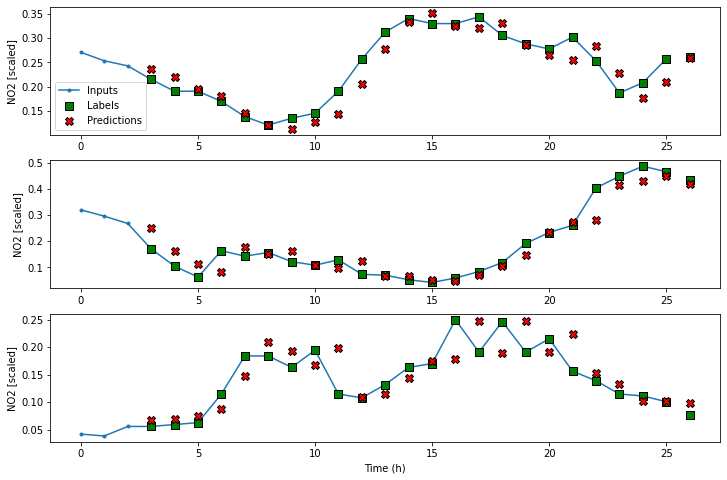

In [7]:
# visualize the predictions against the labels using the plot method of our data window
wide_conv_window.plot(cnn_model, plot_col='NO2')

In [8]:
# Mean Absolute Error
print(performance['CNN'][1])

0.03189410641789436


In [9]:
# Combine the CNN and LSTM architectures into a single model

# Set return_sequences to True to make sure that past information is being used by the network
# define the output layer, a Dense layer = 1, since forecasting is for concentration of Nitrogen oxide only
cnn_lstm_model = Sequential([
    Conv1D(filters=32,
          kernel_size = (KERNEL_WIDTH,),
          activation='relu'),
    LSTM(32, return_sequences=True),
    LSTM(32, return_sequences=True),
    Dense(1)
])

#Train the model
history = compile_and_fit(cnn_lstm_model, conv_window)

val_performance['CNN + LSTM'] = cnn_lstm_model.evaluate(conv_window.val)
performance['CNN + LSTM'] = cnn_lstm_model.evaluate(conv_window.test, verbose=0)

Epoch 1/50
767/767 [==============================] - 61s 59ms/step - loss: 0.0047 - mean_absolute_error: 0.0443 - val_loss: 0.0016 - val_mean_absolute_error: 0.0265
Epoch 2/50
767/767 [==============================] - 21s 27ms/step - loss: 0.0021 - mean_absolute_error: 0.0313 - val_loss: 0.0014 - val_mean_absolute_error: 0.0240 loss: 0.0021 
Epoch 3/50
767/767 [==============================] - 24s 32ms/step - loss: 0.0020 - mean_absolute_error: 0.0301 - val_loss: 0.0018 - val_mean_absolute_error: 0.0308
Epoch 4/50
767/767 [==============================] - 21s 28ms/step - loss: 0.0020 - mean_absolute_error: 0.0302 - val_loss: 0.0019 - val_mean_absolute_error: 0.0331
Epoch 5/50
767/767 [==============================] - 33s 43ms/step - loss: 0.0020 - mean_absolute_error: 0.0300 - val_loss: 0.0013 - val_mean_absolute_error: 0.0234
Epoch 6/50
767/767 [==============================] - 36s 46ms/step - loss: 0.0020 - mean_absolute_error: 0.0297 - val_loss: 0.0015 - val_mean_absolute_erro

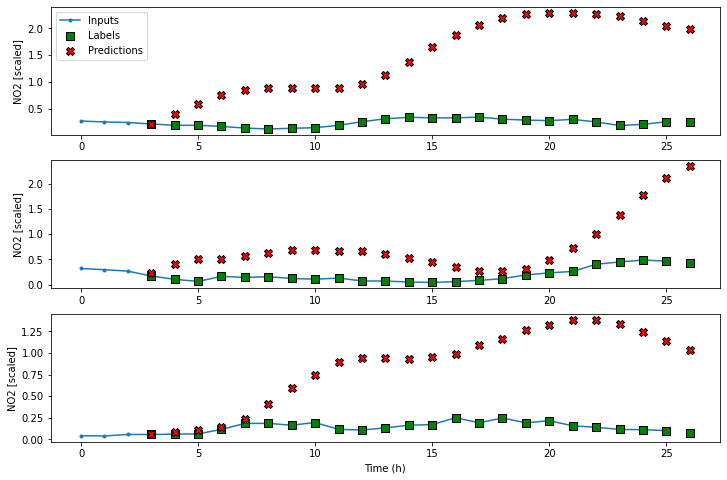

In [10]:
# visualize the predictions against the labels using the plot method of our data window
wide_conv_window.plot(cnn_lstm_model, plot_col='NO2')

In [11]:
# Mean Absolute Error
print(performance['CNN + LSTM'][1])

0.04041484370827675


In [12]:
# List previous single step results to be used for comparison

model_list = ['Baseline - Last', 'Linear', 'Dense', 'LSTM']

mae_val = [0.024, 0.024, 0.026, 0.024]
mae_test = [0.032, 0.032, 0.037, 0.031]

# Add CNN model results
model_list.append('CNN')

mae_val.append(val_performance['CNN'][1])
mae_test.append(performance['CNN'][1])

# Add CNN + LSTM model results
model_list.append('CNN + LSTM')

mae_val.append(val_performance['CNN + LSTM'][1])
mae_test.append(performance['CNN + LSTM'][1])

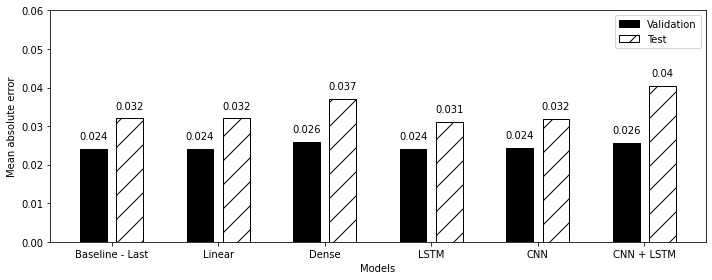

In [13]:
# Compare the MAEs of the CNN, LSTM, DNN linear model and the baseline
x = np.arange(len(model_list))

fig, ax = plt.subplots(figsize=(10,4))
ax.bar(x - 0.17, mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.17, mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel("Mean absolute error")
ax.set_xlabel("Models")

for index, value in enumerate(mae_val):
    plt.text(x=index - 0.17, y=value + 0.0025, s=str(round(value, 3)), ha='center')
    
for index, value in enumerate(mae_test):
    plt.text(x=index + 0.17, y=value + 0.0025, s=str(round(value, 3)), ha='center')
    
plt.ylim(0, 0.06)
plt.xticks(ticks=x, labels=model_list)
plt.legend(loc='best')
plt.tight_layout()

In [14]:
# Implementing a CNN as a multi-step model
# Use the last known 24 hours to forecast the concentration of nitrogen oxide over the next 24 hours
# output length = input length – kernel length + 1
# input length = output length + kernel length – 1

KERNEL_WIDTH = 3
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + KERNEL_WIDTH - 1

multi_window = DataWindow(input_width=INPUT_WIDTH, label_width=LABEL_WIDTH, shift=24,
                         train_df=train_df,
                         val_df = val_df,
                         test_df=test_df,
                         label_columns=['NO2'])

In [15]:
ms_cnn_model = Sequential([
    Conv1D(32, activation='relu', kernel_size=(KERNEL_WIDTH)),
    Dense(units=32, activation='relu'),
    Dense(1, kernel_initializer = tf.initializers.zeros)
])

# train the model
history = compile_and_fit(ms_cnn_model, multi_window)

ms_val_performance = {}
ms_performance = {}

ms_val_performance['CNN'] = ms_cnn_model.evaluate(multi_window.val)
ms_performance['CNN'] = ms_cnn_model.evaluate(multi_window.test, verbose=0)

Epoch 1/50
766/766 [==============================] - 30s 35ms/step - loss: 0.0137 - mean_absolute_error: 0.0894 - val_loss: 0.0090 - val_mean_absolute_error: 0.0756
Epoch 2/50
766/766 [==============================] - 24s 31ms/step - loss: 0.0124 - mean_absolute_error: 0.0856 - val_loss: 0.0088 - val_mean_absolute_error: 0.0738
Epoch 3/50
766/766 [==============================] - 38s 50ms/step - loss: 0.0123 - mean_absolute_error: 0.0853 - val_loss: 0.0087 - val_mean_absolute_error: 0.0721
Epoch 4/50
766/766 [==============================] - 31s 40ms/step - loss: 0.0123 - mean_absolute_error: 0.0850 - val_loss: 0.0098 - val_mean_absolute_error: 0.0783
Epoch 5/50
766/766 [==============================] - 40s 52ms/step - loss: 0.0122 - mean_absolute_error: 0.0848 - val_loss: 0.0098 - val_mean_absolute_error: 0.0771
Epoch 6/50
218/218 [==============================] - 5s 22ms/step - loss: 0.0119 - mean_absolute_error: 0.0874


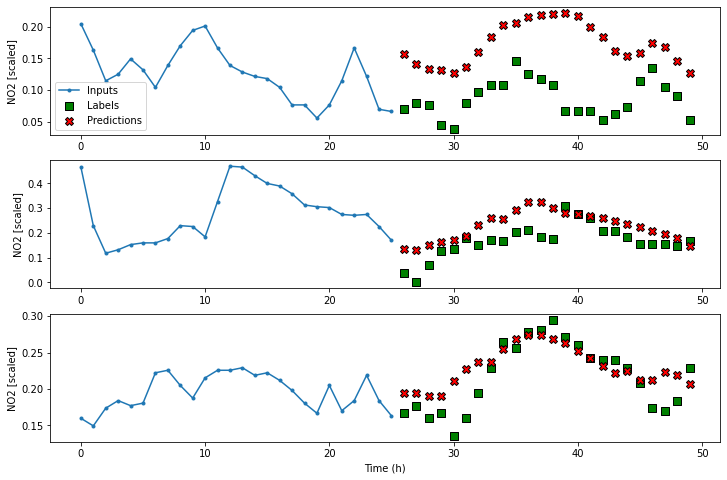

In [16]:
multi_window.plot(ms_cnn_model, plot_col='NO2')

In [17]:
print(ms_performance['CNN'][1])

0.11331524699926376


In [18]:
# Combine the CNN and LSTM architectures into a single model
ms_cnn_lstm_model = Sequential([
    Conv1D(filters=32,
          kernel_size=(KERNEL_WIDTH,),
          activation='relu'),
    LSTM(32, return_sequences=True),
    Dense(1, kernel_initializer=tf.initializers.zeros)    
])

history = compile_and_fit(ms_cnn_lstm_model, multi_window)

ms_val_performance['CNN + LSTM'] = ms_cnn_lstm_model.evaluate(multi_window.val)
ms_performance['CNN + LSTM'] = ms_cnn_lstm_model.evaluate(multi_window.test, verbose=0)

Epoch 1/50
766/766 [==============================] - 72s 80ms/step - loss: 0.0141 - mean_absolute_error: 0.0910 - val_loss: 0.0093 - val_mean_absolute_error: 0.0770
Epoch 2/50
766/766 [==============================] - 65s 85ms/step - loss: 0.0125 - mean_absolute_error: 0.0859 - val_loss: 0.0085 - val_mean_absolute_error: 0.0714
Epoch 3/50
766/766 [==============================] - 69s 90ms/step - loss: 0.0125 - mean_absolute_error: 0.0857 - val_loss: 0.0097 - val_mean_absolute_error: 0.0784
Epoch 4/50
766/766 [==============================] - 56s 72ms/step - loss: 0.0125 - mean_absolute_error: 0.0857 - val_loss: 0.0104 - val_mean_absolute_error: 0.0814
Epoch 5/50
766/766 [==============================] - 46s 59ms/step - loss: 0.0123 - mean_absolute_error: 0.0853 - val_loss: 0.0084 - val_mean_absolute_error: 0.0716
Epoch 6/50
766/766 [==============================] - 41s 53ms/step - loss: 0.0122 - mean_absolute_error: 0.0847 - val_loss: 0.0086 - val_mean_absolute_error: 0.0722
Epoc

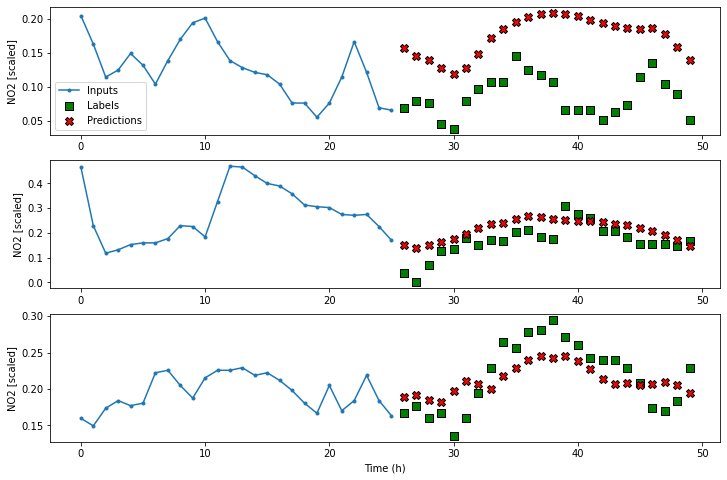

In [19]:
multi_window.plot(ms_cnn_lstm_model, plot_col='NO2')

In [20]:
print(ms_performance['CNN + LSTM'][1])

0.11337804794311523


In [21]:
# List previous multi step results to be used for comparison

multi_model_list = ['Baseline - Last', 'Baseline - Repeat', 'Linear', 'Dense', 'LSTM']

multi_mae_val = [0.33, 0.328, 0.08, 0.079, 0.072]
multi_mae_test = [0.257, 0.267, 0.109, 0.112, 0.108]

# Add CNN model results
multi_model_list.append('CNN')

multi_mae_val.append(ms_val_performance['CNN'][1])
multi_mae_test.append(ms_performance['CNN'][1])

# Add CNN + LSTM model results
multi_model_list.append('CNN + LSTM')

multi_mae_val.append(ms_val_performance['CNN + LSTM'][1])
multi_mae_test.append(ms_performance['CNN + LSTM'][1])

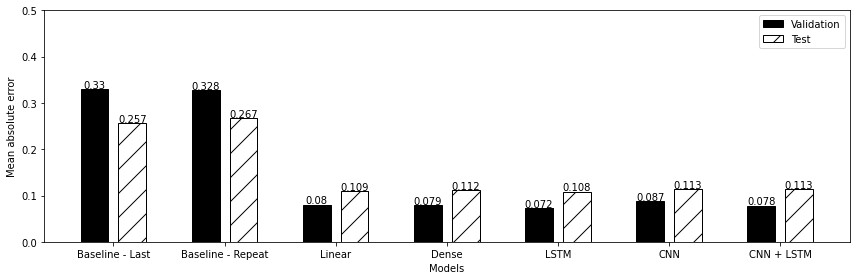

In [22]:
# Compare the MAEs of the CNN, LSTM, DNN linear model and the baselines
x = np.arange(len(multi_model_list))

fig, ax = plt.subplots(figsize=(12, 4))
ax.bar(x - 0.17, multi_mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.17, multi_mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel("Mean absolute error")
ax.set_xlabel("Models")

for index, value in enumerate(multi_mae_val):
    plt.text(x=index - 0.17, y=value + 0.0025, s=str(round(value, 3)), ha='center')
    
for index, value in enumerate(multi_mae_test):
    plt.text(x=index + 0.17, y=value + 0.0025, s=str(round(value, 3)), ha='center')
    
plt.ylim(0, 0.5)
plt.xticks(ticks=x, labels=multi_model_list)
plt.legend(loc='best')
plt.tight_layout()

In [23]:
# Implementing a CNN as a multi-output model
# Forecast the temperature and concentration of nitrogen oxide for the next timestep only
# output length = input length – kernel length + 1
# input length = output length + kernel length – 1

KERNEL_WIDTH = 3
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + KERNEL_WIDTH - 1

wide_mo_conv_window = DataWindow(input_width=INPUT_WIDTH, label_width=LABEL_WIDTH, shift=1,
                                train_df=train_df,
                                val_df=val_df,
                                test_df=test_df,
                                label_columns=['TEMP', 'NO2'])

In [24]:
mo_cnn_model = Sequential([
    Conv1D(filters=32, kernel_size=(KERNEL_WIDTH,), activation='relu'),
    Dense(units=32, activation='relu'),
    Dense(units=2)
])

history = compile_and_fit(mo_cnn_model, wide_mo_conv_window)

mo_val_performance = {}
mo_performance = {}

mo_val_performance['CNN'] = mo_cnn_model.evaluate(wide_mo_conv_window.val)
mo_performance['CNN'] = mo_cnn_model.evaluate(wide_mo_conv_window.test, verbose=0)

Epoch 1/50
767/767 [==============================] - 18s 21ms/step - loss: 0.0088 - mean_absolute_error: 0.0473 - val_loss: 0.0010 - val_mean_absolute_error: 0.0216
Epoch 2/50
767/767 [==============================] - 16s 21ms/step - loss: 0.0012 - mean_absolute_error: 0.0223 - val_loss: 8.8885e-04 - val_mean_absolute_error: 0.0189_absolute
Epoch 3/50
767/767 [==============================] - 16s 20ms/step - loss: 0.0011 - mean_absolute_error: 0.0208 - val_loss: 8.6394e-04 - val_mean_absolute_error: 0.0181 ETA: 0s - loss: 0.0011 - mean_absol
Epoch 4/50
767/767 [==============================] - 16s 21ms/step - loss: 0.0011 - mean_absolute_error: 0.0206 - val_loss: 8.7001e-04 - val_mean_absolute_error: 0.0179s - loss: 0.0011 - mean_a - ETA: 0s - loss: 0.0011 - mean_absolute_error:
Epoch 5/50
767/767 [==============================] - 16s 20ms/step - loss: 0.0011 - mean_absolute_error: 0.0205 - val_loss: 8.5236e-04 - val_mean_absolute_error: 0.0178
Epoch 6/50
767/767 [================

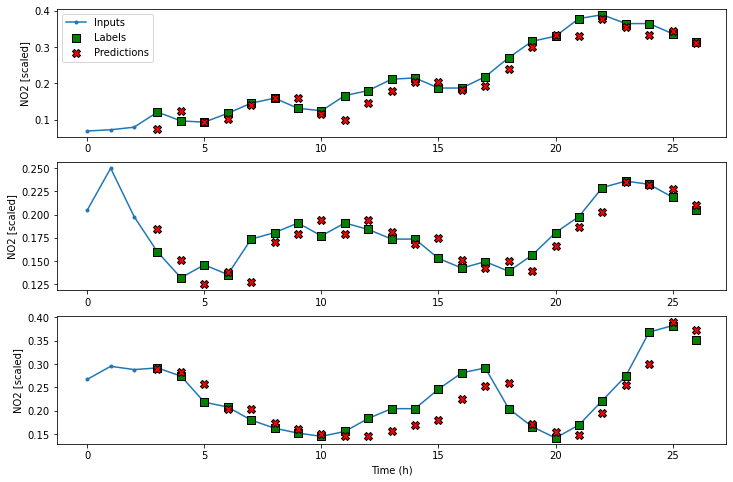

In [25]:
wide_mo_conv_window.plot(mo_cnn_model, plot_col='NO2')

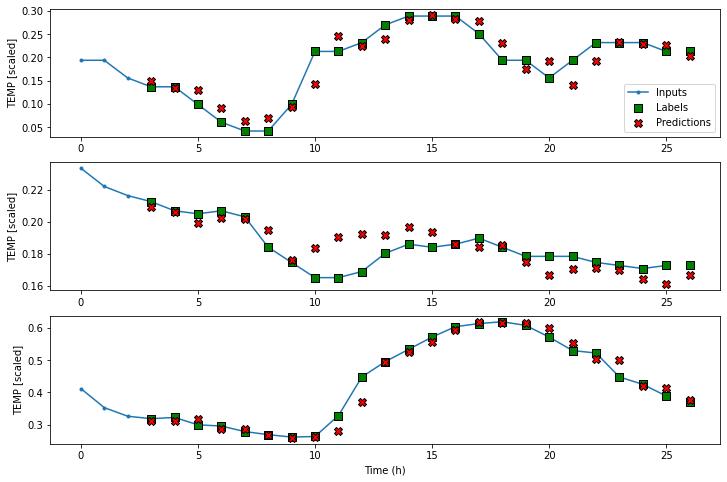

In [26]:
wide_mo_conv_window.plot(mo_cnn_model, plot_col='TEMP')

In [27]:
print(mo_performance['CNN'][1])

0.023509331047534943


In [28]:
# Combine the CNN architecture with the LSTM architecture

mo_cnn_lstm_model = Sequential([
    Conv1D(filters=32, kernel_size=(KERNEL_WIDTH,), activation='relu'),
    LSTM(32, return_sequences=True),
    Dense(units=2)
])

history = compile_and_fit(mo_cnn_lstm_model, wide_mo_conv_window)

mo_val_performance['CNN + LSTM'] = mo_cnn_model.evaluate(wide_mo_conv_window.val)
mo_performance['CNN + LSTM'] = mo_cnn_model.evaluate(wide_mo_conv_window.test, verbose=0)

Epoch 1/50
767/767 [==============================] - 52s 58ms/step - loss: 0.0045 - mean_absolute_error: 0.0405 - val_loss: 0.0010 - val_mean_absolute_error: 0.0213 - mean_absol
Epoch 2/50
767/767 [==============================] - 44s 57ms/step - loss: 0.0013 - mean_absolute_error: 0.0231 - val_loss: 8.7703e-04 - val_mean_absolute_error: 0.0187
Epoch 3/50
767/767 [==============================] - 44s 57ms/step - loss: 0.0012 - mean_absolute_error: 0.0216 - val_loss: 8.4543e-04 - val_mean_absolute_error: 0.0179
Epoch 4/50
767/767 [==============================] - 41s 53ms/step - loss: 0.0011 - mean_absolute_error: 0.0210 - val_loss: 9.7155e-04 - val_mean_absolute_error: 0.0201
Epoch 5/50
767/767 [==============================] - 40s 52ms/step - loss: 0.0011 - mean_absolute_error: 0.0208 - val_loss: 8.4729e-04 - val_mean_absolute_error: 0.0177
Epoch 6/50
767/767 [==============================] - 41s 54ms/step - loss: 0.0011 - mean_absolute_error: 0.0207 - val_loss: 8.3760e-04 - val

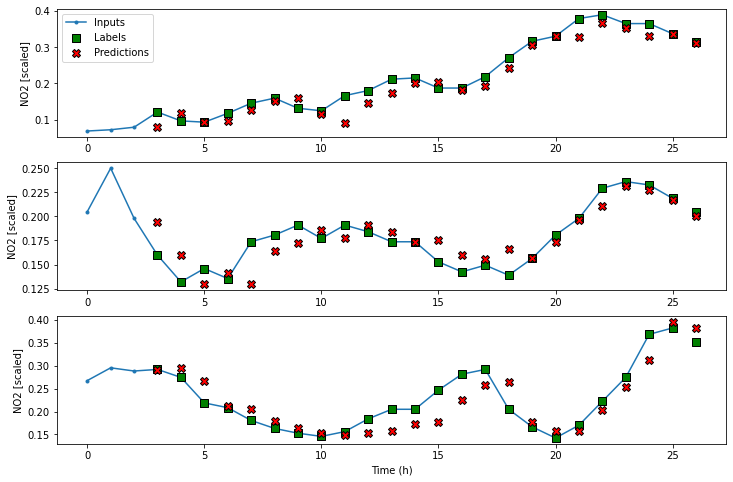

In [29]:
wide_mo_conv_window.plot(mo_cnn_lstm_model, plot_col='NO2')

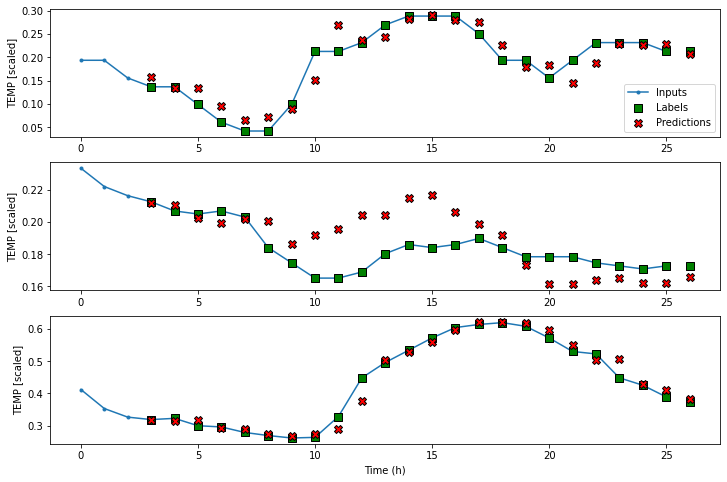

In [30]:
wide_mo_conv_window.plot(mo_cnn_lstm_model, plot_col='TEMP')

In [31]:
print(mo_performance['CNN + LSTM'][1])

0.02350933477282524


In [32]:
# List previous multi output results to be used for comparison

mo_model_list = ['Baseline - Last', 'Linear', 'Dense', 'LSTM']

mo_mae_val = [0.02, 0.019, 0.023, 0.019]
mo_mae_test = [0.024, 0.023, 0.028, 0.023]

# Add CNN model results
mo_model_list.append('CNN')

mo_mae_val.append(mo_val_performance['CNN'][1])
mo_mae_test.append(mo_performance['CNN'][1])

# Add CNN + LSTM model results
mo_model_list.append('CNN + LSTM')

mo_mae_val.append(mo_val_performance['CNN + LSTM'][1])
mo_mae_test.append(mo_performance['CNN + LSTM'][1])

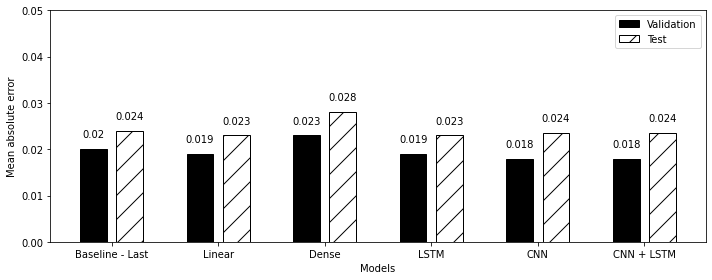

In [33]:
# Compare the MAEs of the LSTM, DNN linear model and the baselines
x = np.arange(len(mo_model_list))

fig, ax = plt.subplots(figsize=(10,4))
ax.bar(x - 0.17, mo_mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.17, mo_mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel("Mean absolute error")
ax.set_xlabel("Models")

for index, value in enumerate(mo_mae_val):
    plt.text(x=index - 0.17, y=value + 0.0025, s=str(round(value, 3)), ha='center')
    
for index, value in enumerate(mo_mae_test):
    plt.text(x=index + 0.17, y=value + 0.0025, s=str(round(value, 3)), ha='center')
    
plt.ylim(0, 0.05)
plt.xticks(ticks=x, labels=mo_model_list)
plt.legend(loc='best')
plt.tight_layout()

In [34]:
# Record end time

end = dt.now()
elapsed = end - start

print("The program took: %02d:%02d:%02d:%02d" % (elapsed.days, elapsed.seconds // 3600, elapsed.seconds // 60 % 60, elapsed.seconds % 60))

The program took: 00:00:33:04
